## Topic Modelling using Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA) in sklearn

### **There also exists implementation using the Gensim library. Checkout the same [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)  ,   [here](https://nlpforhackers.io/topic-modeling/) and [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) and also in [this](https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb) notebook.**

## [Please star/upvote in case u like it. ]

#### IMPORTING MODULES

In [16]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
!wget https://github.com/franciscadias/data/raw/master/abcnews-date-text.csv

--2023-05-26 03:13:52--  https://github.com/franciscadias/data/raw/master/abcnews-date-text.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv [following]
--2023-05-26 03:13:52--  https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54096356 (52M) [text/plain]
Saving to: ‘abcnews-date-text.csv.1’

abcnews-date-text.c 100%[===================>]  51.59M  --.-KB/s    in 0.1s    

2023-05-26 03:13:53 (416 MB/s) - ‘abcnews-date-text.csv.1’ saved [54096356/54096356]



#### LOADING THE DATASET

In [18]:
df=pd.read_csv(r'abcnews-date-text.csv')

In [19]:
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


We will drop the **'publish_date'** column as it is useless for our discussion.

In [20]:
# drop the publish date.
df.drop(['publish_date'],axis=1,inplace=True)

In [21]:
df.head(10)

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
5,ambitious olsson wins triple jump
6,antic delighted with record breaking barca
7,aussie qualifier stosur wastes four memphis match
8,aust addresses un security council over iraq
9,australia is locked into war timetable opp


#### DATA CLEANING & PRE-PROCESSING

Here I have done the data pre-processing. I have used the lemmatizer and can also use the stemmer. Also the stop words have been used along with the words wit lenght shorter than 3 characters to reduce some stray words.

In [22]:
def clean_text(headline):
  le=WordNetLemmatizer()
  word_tokens=word_tokenize(headline)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
  cleaned_text=" ".join(tokens)
  return cleaned_text
  
  

In [23]:
# time taking
df['headline_cleaned_text']=df['headline_text'].apply(clean_text)

In [24]:
df.head()

,headline_text,headline_cleaned_text
0,aba decides against community broadcasting lic...,decides community broadcasting licence
1,act fire witnesses must be aware of defamation,fire witness must aware defamation
2,a g calls for infrastructure protection summit,call infrastructure protection summit
3,air nz staff in aust strike for pay rise,staff aust strike rise
4,air nz strike to affect australian travellers,strike affect australian traveller


Can see the difference after removal of stopwords and some shorter words. aslo the words have been lemmatized as in **'calls'--->'call'.**

Now drop the unpre-processed column.

In [25]:
df.drop(['headline_text'],axis=1,inplace=True)

In [26]:
df.head()

,headline_cleaned_text
0,decides community broadcasting licence
1,fire witness must aware defamation
2,call infrastructure protection summit
3,staff aust strike rise
4,strike affect australian traveller


We can also see any particular news headline.

In [27]:
df['headline_cleaned_text'][0]

'decides community broadcasting licence'

#### EXTRACTING THE FEATURES AND CREATING THE DOCUMENT-TERM-MATRIX ( DTM )

In DTM the values are the TFidf values.

Also I have specified some parameters of the Tfidf vectorizer.

Some important points:-

**1) LSA is generally implemented with Tfidf values everywhere and not with the Count Vectorizer.**

**2) max_features depends on your computing power and also on eval. metric (coherence score is a metric for topic model). Try the value that gives best eval. metric and doesn't limits processing power.**

**3) Default values for min_df & max_df worked well.**

**4) Can try different values for ngram_range.**

In [30]:
vect =TfidfVectorizer(stop_words='english',max_features=1000) # to play with. min_df,max_df,max_features etc...

In [31]:
vect_text=vect.fit_transform(df['headline_cleaned_text'])

#### We can now see the most frequent and rare words in the news headlines based on idf score. The lesser the value; more common is the word in the news headlines.

In [32]:
print(vect_text.shape)
print(vect_text)

(1082168, 1000)
  (0, 506)	0.7808501086213628
  (0, 180)	0.6247184228642579
  (1, 983)	1.0
  (2, 854)	0.588431265740015
  (2, 682)	0.5558728359650339
  (2, 439)	0.5871575902053846
  (3, 745)	0.45561263771118865
  (3, 845)	0.4894613050417399
  (3, 53)	0.5173202827071665
  (3, 830)	0.5340641163048379
  (4, 55)	0.6517883688248135
  (4, 845)	0.7584008981170111
  (5, 471)	0.7945298311708796
  (5, 979)	0.6072251208403467
  (6, 710)	1.0
  (7, 541)	0.5891566785007057
  (7, 961)	0.6169659131661696
  (7, 52)	0.5217733896712735
  (8, 451)	0.42599471057363225
  (8, 202)	0.3474890814735176
  (8, 779)	0.45121644329829264
  (8, 12)	0.526784588388066
  (8, 53)	0.4654906696745199
  (9, 54)	1.0
  (10, 555)	0.64576079135097
  :	:
  (1082157, 311)	0.4472935023390685
  (1082158, 942)	0.6101513895706319
  (1082158, 834)	0.579845157404016
  (1082158, 710)	0.5399026534849953
  (1082159, 6)	0.7509739654481693
  (1082159, 269)	0.6603318129690952
  (1082160, 257)	0.5085761540845598
  (1082160, 767)	0.33784313843

In [33]:
idf=vect.idf_

In [35]:
dd=dict(zip(vect.get_feature_names_out(), idf))
l=sorted(dd, key=(dd).get)
# print(l)
print(l[0],l[-1])
print(dd['police'])
print(dd['forecast'])  # police is most common and forecast is least common among the news headlines.

police justice
4.421282814390084
7.939839053547438


We can therefore see that on the basis of the **idf value** , **'police'** is the **most frequent** word while **'forecast'** is **least frequently** occuring among the news.

### TOPIC MODELLING

## Latent Semantic Analysis (LSA)

The first approach that I have used is the LSA. **LSA is basically singular value decomposition.**

**SVD decomposes the original DTM into three matrices S=U.(sigma).(V.T). Here the matrix U denotes the document-topic matrix while (V) is the topic-term matrix.**

**Each row of the matrix U(document-term matrix) is the vector representation of the corresponding document. The length of these vectors is the number of desired topics. Vector representation for the terms in our data can be found in the matrix V (term-topic matrix).**

So, SVD gives us vectors for every document and term in our data. The length of each vector would be k. **We can then use these vectors to find similar words and similar documents using the cosine similarity method.**

We can use the truncatedSVD function to implement LSA. The n_components parameter is the number of topics we wish to extract.
The model is then fit and transformed on the result given by vectorizer. 

**Lastly note that LSA and LSI (I for indexing) are the same and the later is just sometimes used in information retrieval contexts.**

In [36]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)


In [37]:
print(lsa_top)
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[[ 9.50916064e-05  8.20387886e-03  2.29881404e-02 ...  9.96969215e-03
   4.76054089e-04  5.05618406e-03]
 [ 3.90822904e-04  1.85591276e-02  3.54386492e-04 ...  1.92354293e-03
   4.71114751e-03 -3.68575087e-03]
 [ 5.31043513e-05  3.22629288e-03  1.15209591e-02 ...  5.33212682e-03
  -1.78365499e-03  3.41142417e-03]
 ...
 [ 1.34372446e-04  1.11781942e-02  2.30649765e-02 ...  2.09386864e-02
   1.78016890e-02  2.03135324e-02]
 [ 8.46707818e-04  5.13681594e-02  1.22051914e-01 ...  8.80368346e-03
   1.36876201e-01 -7.40487247e-02]
 [ 7.81175609e-04  9.02682653e-02  4.98487176e-02 ...  8.49899658e-02
   1.43622699e-01  6.22205028e-02]]
(1082168, 10)


In [38]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)
  


Document 0 :
Topic  0  :  0.009509160638345568
Topic  1  :  0.8203878864694947
Topic  2  :  2.2988140421270074
Topic  3  :  -0.6931044402501757
Topic  4  :  0.01598526923469361
Topic  5  :  0.20188152110668958
Topic  6  :  -0.40748821947696734
Topic  7  :  0.9969692145990025
Topic  8  :  0.0476054089207299
Topic  9  :  0.5056184059339724


Similalry for other documents we can do this. However note that values dont add to 1 as in LSA it is not probabiltiy of a topic in a document.

In [39]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(10, 1000)
[[ 1.56033728e-05  2.10761799e-05  5.42364683e-05 ...  5.71771743e-05
   2.81267960e-05  3.36323310e-05]
 [ 6.45566592e-04  9.33495758e-04  1.04738551e-03 ...  1.34443635e-03
   1.98843741e-03  2.20249468e-03]
 [ 2.17425277e-03  3.35943169e-03  3.74732014e-03 ...  3.60945249e-03
   3.98706179e-03  5.21836758e-03]
 ...
 [ 1.55521073e-03  2.43851931e-03  2.33411382e-03 ... -1.29444762e-03
   1.97934390e-03  1.69314976e-03]
 [ 1.53539005e-03  2.81046492e-03  2.31611254e-03 ... -2.93502217e-04
  -1.31244148e-03  4.09042107e-04]
 [ 1.91654809e-03  2.95546829e-03  2.98333576e-03 ...  2.68298306e-04
   1.48601651e-03  5.94729158e-04]]


#### Now e can get a list of the important words for each of the 10 topics as shown. For simplicity here I have shown 10 words for each topic.

In [41]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         

Topic 0: 
interview extended michael john david smith james andrew police mark 

Topic 1: 
police death probe crash woman court missing investigate search drug 

Topic 2: 
say plan council govt court water australia report face change 

Topic 3: 
say australia court world australian woman report death minister need 

Topic 4: 
court face woman murder charge accused charged death crash drug 

Topic 5: 
australia world south australian test report year woman win lead 

Topic 6: 
council australia rate say rise seek election land considers court 

Topic 7: 
govt crash report woman urged australian dy death hospital claim 

Topic 8: 
crash woman charged dy death plan killed australian sydney year 

Topic 9: 
report australian water open market year win death health rise 



## Latent Dirichlet Allocation (LDA)  

LDA is the most popular technique.**The topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.**

**To understand the maths it seems as if knowledge of Dirichlet distribution (distribution of distributions) is required which is quite intricate and left fior now.**

To get an inituitive explanation of LDA checkout these blogs: [this](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)  ,  [this](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)  ,[this](https://en.wikipedia.org/wiki/Topic_model)  ,  [this kernel on Kaggle](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)  ,  [this](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) .

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [43]:
lda_top=lda_model.fit_transform(vect_text)

In [44]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)


(1082168, 10)
[[0.04157021 0.04157021 0.04157021 ... 0.04157021 0.62586807 0.04157021]
 [0.05       0.05       0.05       ... 0.05       0.55       0.05      ]
 [0.03661043 0.03661043 0.03661043 ... 0.03661043 0.03661043 0.03661043]
 ...
 [0.24511154 0.03660825 0.03660825 ... 0.03660825 0.25451989 0.03660825]
 [0.16689446 0.03099384 0.15798299 ... 0.03099384 0.03099384 0.15598726]
 [0.05       0.05       0.05       ... 0.05       0.55       0.05      ]]


In [45]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)  

1.0


#### Note that the values in a particular row adds to 1. This is beacuse each value denotes the % of contribution of the corressponding topic in the document.

In [46]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  4.157021456357171 %
Topic  1 :  4.157021456355388 %
Topic  2 :  4.157021456357976 %
Topic  3 :  4.157021456371127 %
Topic  4 :  4.157021456360439 %
Topic  5 :  4.157021456357027 %
Topic  6 :  4.157021456358314 %
Topic  7 :  4.157021456364183 %
Topic  8 :  62.586806892754176 %
Topic  9 :  4.157021456364205 %


#### As we can see Topic 7 & 8 are dominantly present in document 0.

 

In [47]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

[[1.00001468e-01 1.13601714e+03 1.00008834e-01 ... 1.00004700e-01
  1.00002361e-01 1.00001898e-01]
 [1.00001161e-01 1.00001105e-01 3.50277260e+03 ... 1.00003992e-01
  1.00002061e-01 1.00004829e-01]
 [1.00000540e-01 1.00001365e-01 1.00002506e-01 ... 1.00004465e-01
  1.00004096e-01 1.00005418e-01]
 ...
 [1.00001267e-01 1.00002038e-01 1.00006392e-01 ... 1.00004327e-01
  1.00001437e-01 1.00002768e-01]
 [3.51788362e+02 1.00001372e-01 1.00004288e-01 ... 1.80531842e+03
  1.51831176e+02 1.00002837e-01]
 [1.00001445e-01 1.00001502e-01 1.00005750e-01 ... 1.00009557e-01
  1.00001294e-01 1.00007227e-01]]
(10, 1000)


#### Most important words for a topic. (say 10 this time.)

In [49]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
australian world interview country north state hospital dy west budget 

Topic 1: 
trump year melbourne queensland 2016 market league power share 2015 

Topic 2: 
police woman child school open plan farmer accused driver industry 

Topic 3: 
say change health minister news case fall killed return mother 

Topic 4: 
government south canberra home life brisbane crash win labor island 

Topic 5: 
court murder rural china drug indigenous face price charge claim 

Topic 6: 
adelaide perth report test hour trial make victorian federal darwin 

Topic 7: 
sydney charged national house council final help turnbull funding water 

Topic 8: 
election death attack tasmania family people community time live service 

Topic 9: 
australia coast tasmanian victoria gold missing road john million search 



#### To better visualize words in a topic we can see the word cloud. For each topic top 50 words are plotted.

In [50]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

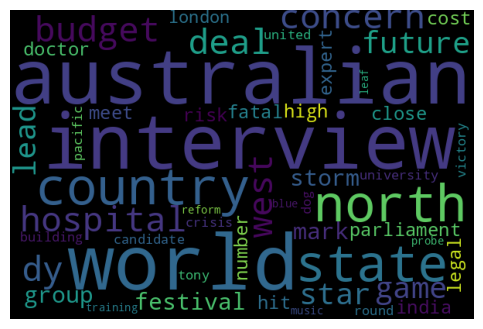

In [51]:
# topic 0
draw_word_cloud(0)

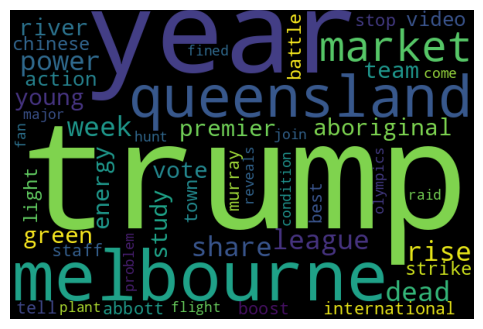

In [52]:
# topic 1
draw_word_cloud(1)  # ...

## THE END !!!

## [Please star/upvote in case u liked it. ]